# Data Acquisition

This notebook is for acquiring our album cover data.

## Preliminaries

In [3]:
# Imports 

# General
from dotenv import load_dotenv
import os, pathlib
import requests
import pandas as pd
from tqdm import tqdm
import csv
from pathlib import Path
import time
import numpy as np

# Visualizations
import matplotlib.pyplot as plt

# Custom
from utils.general import examine_df

In [12]:
# Set global variables

MB_MIN_DELAY = 1.5   # seconds between MusicBrainz calls
CAA_MIN_DELAY = 0.7  # seconds between image downloads

START_YEAR = 1950
END_YEAR   = 2019 

PROJECT_DIR = Path("C:/Users/emshe/Desktop/REPOS/album-cover-release-year-predictions")  
COVERS_DIR  = PROJECT_DIR / "covers" # This changed
CSV_PATH    = PROJECT_DIR / "album_covers.csv" # This changed

USER_AGENT = "AlbumYearDataset/0.1 (emshelburne; contact: shelburneethan@gmail.com)"

In [5]:
# Load Discogs API token

load_dotenv()  # loads .env from current working directory
TOKEN = os.getenv("DISCOGS_TOKEN")
print("TOKEN is set:", TOKEN is not None)

TOKEN is set: True


## Getting Albums from Cover Art Archive

In [28]:
# Start HTTP session

session = requests.Session()
session.headers.update({"User-Agent": USER_AGENT})

### Helper functions

In [1]:
# Function to get albums by year

def get_albums_by_year(year: int , limit: int = 100, offset: int = 0) -> list:

    '''
    Get n (=limit) albums from Cover Art Archive API
    '''
    
    url = f"https://musicbrainz.org/ws/2/release?query=date:{year}&fmt=json&limit={limit}&offset={offset}"
    
    r = mb_get(url)  # Includes pauses
    
    r.raise_for_status()
    
    return r.json().get("releases", [])

In [25]:
# Function to send HTTP GET to the MusicBrainz API

def mb_get(url: str, **kwargs) -> requests.Response | None:
    
    """
    Polite MusicBrainz GET with a fixed pause after each reques + timeout + fixed sleep + 429 retry.
    """
    
    try:
        r = session.get(url, timeout=25, **kwargs)
        if r.status_code == 429:
            # Honor Retry - after if present, else sleep 3s
            retry_after = float(r.headers.get("Retry-After", "3"))
            time.sleep(retry_after)
            r = session.get(url, timeout=25, **kwargs)
        time.sleep(MB_MIN_DELAY)
        return r
        
    except requests.RequestException:
        # Brief cooldown 
        time.sleep(3)
        raise

In [8]:
# Function to make a single, polite HTTP GET to fetch album art from Cover Art Archive 

def caa_get(url: str, stream: bool = False, **kwargs) -> requests.Response | None:
    
    """
    Polite CAA GET with a small pause after each request
    """
    
    try:
        r = session.get(url, timeout=40, stream=stream, **kwargs)
        time.sleep(CAA_MIN_DELAY)
        return r
    except requests.RequestException:
        time.sleep(2)
        raise

In [7]:
# Function to query one page of releases for a specific year

def get_releases_page(year: int, limit:int = 100, offset:int = 0) -> list:
    
    """
    One page of releases for a year (MB limit max=100).
    """
    
    url = f"https://musicbrainz.org/ws/2/release?query=date:{year}&fmt=json&limit={limit}&offset={offset}"
    r = mb_get(url)
    if r.status_code != 200:
        return []
    return r.json().get("releases", []) or []

In [9]:
# Function to get cover art (simple version)

def get_cover_url(mbid: str) -> str:
    
    '''
    Get cover art from MusicBrainz ID via asking for the 500px thumbnail directly
    '''
    
    return f"https://coverartarchive.org/release/{mbid}/front-500"

In [11]:
# Generator that paginates through all releases for given year

def iter_releases_by_year(year: int , max_pages: int | bool =None) -> None:

    """
    - Repeatedly calls get_albums_by_year(year, limit=100, offset=k*100)
    - Yields each release dict to your loop
    - Stops when a page returns <100 items or when max_pages is reached.
    """
    
    per_page = 100
    offset = 0
    pages = 0
    
    while True:
        rels = get_releases_page(year, limit=per_page, offset=offset)
        if not rels:
            break
        for rel in rels:
            yield rel
        offset += per_page
        pages += 1
        if len(rels) < per_page:
            break
        if max_pages is not None and pages >= max_pages:
            break

In [12]:
# Function to create csv if it does not exist

def ensure_csv_header(path: Path)-> None:

    '''
    Creates csv if not present
    '''
    
    write_header = not path.exists()
    if write_header:
        with open(path, "w", newline="", encoding="utf-8") as f:
            w = csv.writer(f)
            w.writerow(["mbid", "artist", "title", "year", "image_url", "local_path"])

In [13]:
# Function to append one line of album metadata to the csv

def append_row(path: Path, row: tuple) -> None:

    '''
    Appends one line of data to csv
    '''
    
    with open(path, "a", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(row)

### Collect Data

In [34]:
# Test getting albums by year

albums = get_albums_by_year(1998)

print(f"Example record:\n\n {albums[0]}")

Example record:

 {'id': '5831885a-b6af-4f4e-9ec4-f8d928b49c3c', 'score': 100, 'status-id': '4e304316-386d-3409-af2e-78857eec5cfe', 'packaging-id': 'ec27701a-4a22-37f4-bfac-6616e0f9750a', 'artist-credit-id': '657f698c-a2cd-398c-ba6a-e9e0765c9fe6', 'count': 1, 'title': 'Trail of the Lonesome Pine', 'status': 'Official', 'packaging': 'Jewel Case', 'text-representation': {'language': 'eng', 'script': 'Latn'}, 'artist-credit': [{'name': 'Laurel & Hardy', 'artist': {'id': '4a8ae4fd-ad6f-4912-851f-093f12ee3572', 'name': 'Laurel & Hardy', 'sort-name': 'Laurel & Hardy', 'disambiguation': 'Comedy Duo'}}], 'release-group': {'id': 'f0f6f26f-d89a-300b-b2a1-713cb06604c7', 'type-id': '22a628ad-c082-3c4f-b1b6-d41665107b88', 'primary-type-id': 'f529b476-6e62-324f-b0aa-1f3e33d313fc', 'title': 'Trail of the Lonesome Pine', 'primary-type': 'Album', 'secondary-types': ['Soundtrack'], 'secondary-type-ids': ['22a628ad-c082-3c4f-b1b6-d41665107b88']}, 'date': '1998', 'country': 'GB', 'release-events': [{'date

In [35]:
# Inspect keys

print(f"Keys:\n\n {albums[0].keys()}")

Keys:

 dict_keys(['id', 'score', 'status-id', 'packaging-id', 'artist-credit-id', 'count', 'title', 'status', 'packaging', 'text-representation', 'artist-credit', 'release-group', 'date', 'country', 'release-events', 'barcode', 'asin', 'label-info', 'track-count', 'media'])


##### Attempt 1

In [37]:
# # Collect album data from 1960 to 2024

# records = []
# for year in range(1960, 2024):
    
#     # Iterate with paging to stay clean
    
#     for rel in iter_year_releases(year):
        
#         mbid = rel["id"]
#         artist = rel["artist-credit"][0]["artist"]["name"] if rel.get("artist-credit") else "Unknown"
#         title  = rel.get("title", "")
#         date   = rel.get("date", str(year))
#         img_url = get_cover_url(mbid)

#         img_path = f"{PATH}/covers/{year}_{mbid}.jpg"
        
#         try:
#             # Polite image fetch (adds ~0.5s pause)
#             img_data = caa_get(img_url, stream=True)
#             if img_data.status_code == 200 and img_data.headers.get("Content-Type","").startswith("image/"):
#                 with open(img_path, "wb") as f:
#                     for chunk in img_data.iter_content(65536):
#                         if chunk:
#                             f.write(chunk)
#                 records.append((mbid, artist, title, date, img_url, img_path))
        
#         except requests.RequestException:
            
#             # Brief cooldown on network hiccup; then continue
            
#             time.sleep(2.0)
#             continue


The above loop eventually timed out. Checking via terminal, we collected 876 covers. All are from 1960. 

Attempt 2

In [54]:
# Attempt crawl from 1948 to 2024

ensure_csv_header(CSV_PATH)

total_downloaded = sum(1 for _ in COVERS_DIR.glob("*.jpg"))  # Current on-disk
print(f"Starting crawl. Already on disk: {total_downloaded} images\n")

for year in range(START_YEAR, END_YEAR):
    year_downloaded = 0
    pages_seen = 0
    had_any_page = False

    try:
        # Iterate through pages for this year
        for rel in iter_releases_by_year(year):
            had_any_page = True

            mbid = rel.get("id")
            if not mbid:
                continue

            # Artist name
            artist = "Unknown"
            ac = rel.get("artist-credit") or []
            if ac and isinstance(ac, list) and ac[0].get("artist"):
                artist = ac[0]["artist"].get("name", "Unknown")

            title = rel.get("title", "")
            date  = rel.get("date", str(year))  # Keep full date if present
            img_url = get_cover_url(mbid)

            img_path = COVERS_DIR / f"{str(year)}_{mbid}.jpg"
            if img_path.exists():
                
                # Already have it; don't re-download. We won't count it as "downloaded this run".
                
                continue

            # Fetch image
            
            try:
                rimg = caa_get(img_url, stream=True)
                if rimg.status_code == 200 and rimg.headers.get("Content-Type", "").startswith("image/"):
                    with open(img_path, "wb") as f:
                        for chunk in rimg.iter_content(65536):
                            if chunk:
                                f.write(chunk)
                    append_row(CSV_PATH, (mbid, artist, title, date, img_url, str(img_path)))
                    year_downloaded += 1
                    total_downloaded += 1
                # 404/other statuses: just skip quietly
            except requests.RequestException:
                # Transient fetch issue; skip this release and continue
                continue

        if not had_any_page:
            print(f"[{year}] no releases found (MB search returned empty).")
        else:
            print(f"[{year}] downloaded this year: {year_downloaded} | total on disk now: {total_downloaded}")

        # Small breather between years
        time.sleep(2)

    except KeyboardInterrupt:
        print("\nInterrupted by user. Exiting cleanly.")
        break
    except Exception as e:
        # Don't crash the whole run if one year hiccups
        print(f"[{year}] encountered an error: {e}. Continuing to next year...")
        time.sleep(3)
        continue

print("\nDone.")

Starting crawl. Already on disk: 876 images

[1948] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing to next year...
[1949] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing to next year...
[1950] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing to next year...
[1951] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing to next year...
[1952] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing t

The above just got this repeating: [1973] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing to next year... This was because I forgot to include my account name on the API as user agent. 

Attempt 3

In [22]:
# Test connectivity quickly

UA = "AlbumYearDataset/0.1 (emshelburne; contact: shelburneethan@gmail.com)"
r = requests.get("https://musicbrainz.org/ws/2/release?query=date:1960&fmt=json&limit=1",
                 headers={"User-Agent": UA}, timeout=15)
print(r.status_code, len(r.content))

200 1614


In [29]:
# Third attempted crawl (1950-2019) with fixed credentials

ensure_csv_header(CSV_PATH)

total_downloaded = sum(1 for _ in COVERS_DIR.glob("*.jpg"))
print(f"Starting crawl. Already on disk: {total_downloaded} images\n")

for year in range(START_YEAR, END_YEAR):  # 1950..2019
    year_downloaded = 0
    had_any_page = False

    try:
        # iterate all pages for the year (your iter_releases_by_year handles paging)
        for rel in iter_releases_by_year(year):
            had_any_page = True

            mbid = rel.get("id")
            if not mbid:
                continue

            # safe artist extraction
            artist = "Unknown"
            ac = rel.get("artist-credit") or []
            if ac and isinstance(ac, list) and ac[0].get("artist"):
                artist = ac[0]["artist"].get("name", "Unknown")

            title = rel.get("title", "") or ""
            date  = rel.get("date", str(year))  # keep full date if present

            # deterministic filename: YEAR_Mbid.jpg
            img_path = COVERS_DIR / f"{year}_{mbid}.jpg"
            if img_path.exists():
                # already have it; skip
                continue

            img_url = get_cover_url(mbid)  # e.g., front-500

            # fetch image (your caa_get already sleeps politely)
            try:
                rimg = caa_get(img_url, stream=True)
                if rimg.status_code == 200 and rimg.headers.get("Content-Type", "").startswith("image/"):
                    with open(img_path, "wb") as f:
                        for chunk in rimg.iter_content(65536):
                            if chunk:
                                f.write(chunk)
                    append_row(CSV_PATH, (mbid, artist, title, date, img_url, str(img_path)))
                    year_downloaded += 1
                    total_downloaded += 1
                # if 404/other, just skip
            except requests.RequestException:
                # transient issue; skip this release only
                continue

        if not had_any_page:
            print(f"[{year}] no releases found (MB search returned empty).")
        else:
            print(f"[{year}] downloaded this year: {year_downloaded} | total on disk now: {total_downloaded}")

        # small breather between years (be nice even if a year had no pages)
        time.sleep(2.0)

    except KeyboardInterrupt:
        print("\nInterrupted by user. Exiting cleanly.")
        break
    except Exception as e:
        print(f"[{year}] encountered an error: {e}. Continuing to next year...")
        time.sleep(3.0)
        continue

print("\nDone.")

Starting crawl. Already on disk: 0 images

[1950] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing to next year...
[1951] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing to next year...
[1952] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing to next year...
[1953] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing to next year...
[1954] encountered an error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)). Continuing to 

Checking Results of Attempt 3

In [53]:
# Load albums csv as dataframe

albums_df = pd.read_csv(PROJECT_DIR/'album_covers.csv')

In [59]:
# Examine albums dataframe

examine_df(albums_df)



Number of records in this dataframe is: 18075



Number of features in this dataframe is: 7

The columns in this dataframe are: Index(['mbid', 'artist', 'title', 'year', 'image_url', 'local_path', 'date'], dtype='object')


 Other info about this dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18075 entries, 0 to 18074
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mbid        18075 non-null  object
 1   artist      18075 non-null  object
 2   title       18075 non-null  object
 3   year        18072 non-null  object
 4   image_url   18075 non-null  object
 5   local_path  18075 non-null  object
 6   date        18072 non-null  object
dtypes: object(7)
memory usage: 988.6+ KB
None

 Basic statistical info about this dataframe:

                                        mbid         artist          title  \
count                                  18075          18075          18075   
unique              

In [58]:
# Extract years from dates

albums_df['date'] = albums_df['year']

albums_df['year'] = albums_df['year'].str[:4]

In [64]:
# Check sample of year distributions

year_counts = albums_df.groupby("year").size().sort_index()
print(year_counts.head(20))
print("\nTotal albums in span:", int(year_counts.sum()))
print("Years covered:", int(year_counts.index.min()), "–", int(year_counts.index.max()))

year
1951    397
1952    612
1953    484
1954    336
1955    691
1956    765
1957    273
1958    180
1959    261
1960    235
1962    581
1963    193
1964     98
1965    220
1967    442
1968     37
1969    197
1970    168
1972     52
1973    108
dtype: int64

Total albums in span: 18072
Years covered: 1951 – 2018


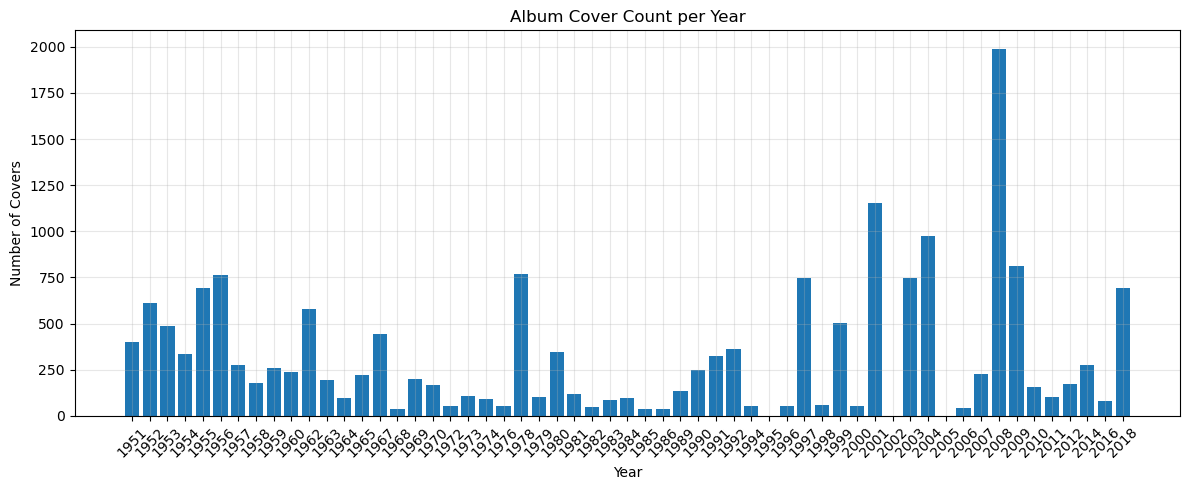

In [72]:
# Plot year distributions

plt.figure(figsize=(12,5))
plt.bar(year_counts.index, year_counts.values)
plt.title("Album Cover Count per Year")
plt.xlabel("Year")
plt.ylabel("Number of Covers")
plt.grid(alpha=0.3)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Getting Albums from Discogs